# ConvNets

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import cv2
import seaborn as sns

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import warnings
warnings.filterwarnings("ignore")

# Import DL libraries and frameworks 

In [3]:
import torch
from torchvision import transforms, datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [4]:
if(torch.cuda.is_available()):
    device = torch.device('cuda:0')
    print('Running on the GPU')
else:
    device = torch.device('cpu')
    print('Running on the CPU')

Running on the CPU


# Navigate to the input data

In [5]:
%cd /kaggle/input/kaggle-cat-vs-dog-dataset/kagglecatsanddogs_3367a/PetImages/

/kaggle/input/kaggle-cat-vs-dog-dataset/kagglecatsanddogs_3367a/PetImages


# Preprocess only when flag is true

In [9]:
flag = True
# flag = False

In [10]:
class Preprocess():
    cat = "./Cat"
    dog = "./Dog"
    labels = {cat : 0, dog : 1}
    training_data = []
    
    def load_train_set(self):
        for label in self.labels:
            for file in tqdm(os.listdir(label)):
                path = label + '/' + file
                try:
                    img = plt.imread(path)[:,:,0]
                    img = cv2.resize(img, (50, 50))
                    self.training_data.append([img, self.labels[label]])
                except:
                    pass
        
        np.random.shuffle(self.training_data)
        np.save("/kaggle/working/Training_Data.npy", self.training_data)

In [11]:
if(flag):
    p = Preprocess()
    p.load_train_set()
    flag = False

train_data = np.load("/kaggle/working/Training_Data.npy", allow_pickle = True)

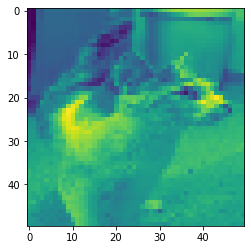

In [12]:
plt.imshow(train_data[0][0])

# Test & Train Split

In [18]:
X = torch.Tensor([i[0] for i in train_data])
X /= 255.0 # normalise these pixel values

y = torch.Tensor([i[1] for i in train_data])

val = len(train_data) // 20
X_test = X[: val]
y_test = y[: val]
X_train = X[val :]
y_train = y[val :]

# Create the Model Graph

In [54]:
class Net(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(1,32,5)
        self.conv2 = nn.Conv2d(32,64,5)
        self.conv3 = nn.Conv2d(64,128,5)
        
        self.fc1 = nn.Linear(512, 128)
        self.fc2 = nn.Linear(128, 2)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x,2,2)
        
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x,2,2)
        
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x,2,2)
        
        batch_size = len(x)
        x = torch.flatten(x)
        x = x.reshape(batch_size, -1)
        
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x

In [55]:
class Rand(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(1,32,5)
        self.conv2 = nn.Conv2d(32,64,5)
        self.conv3 = nn.Conv2d(64,128,5)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x,2,2)
        
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x,2,2)
        
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x,2,2)
        
        x = torch.flatten(x)
        print(x.shape)
        
r = Rand()
p = torch.rand(50,50).view(-1,1,50,50)
r(p)

torch.Size([512])


# Creating the Model

In [75]:
net = Net().to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimiser = optim.Adam(net.parameters(), lr = 0.001)

# Training the Model

In [76]:
f = open('/kaggle/working/loss.txt', 'w')
batch_size = 128
epochs = 2

for _ in range(epochs):
    for i in tqdm(range(0, len(X_train), batch_size)):
        
        X_batch = X_train[i : i + batch_size].view(-1,1,50,50).to(device)
        y_batch = y_train[i : i + batch_size].to(device)

        net.zero_grad()
        pred = net(X_batch)
        
        loss = criterion(pred, y_batch.long())
        
        loss.backward()
        optimiser.step()
        f.write(str(float(loss)) + '\n')
        
        del X_batch, y_batch
        torch.cuda.empty_cache()
    
f.close()

# Plotting the Loss

In [77]:
record = []
f = open('/kaggle/working/loss.txt', 'r')

for line in f:
    record.append(float(line))

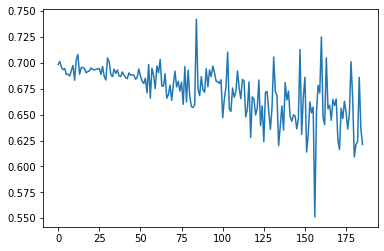

In [78]:
plt.plot(record)

# Testing the Model 

In [79]:
X_test = X_test.view(-1,1,50,50).to(device)
y_test = y_test.to(device)
correct = 0

with torch.no_grad():
    pred = net.forward(X_test) 
    
for i in range(y_test.shape[0]):
    correct += 1 if torch.argmax(pred[i]) == y_test[i] else 0
    
print(correct / y_test.shape[0])

0.6078588612670409
